# Composition and Density

Looking at motif composition, density and influence on reads etc.

In [470]:
import numpy as np 
import pandas as pd
import intervaltree
import pyfaidx
import pyBigWig
import scipy

from random import sample, shuffle
import seaborn as sns
from matplotlib import pyplot as plt
from collections import defaultdict, Counter
from scipy.stats import pearsonr, spearmanr
from copy import deepcopy

In [471]:
MOT_BASE = "./scanning/tfmodisco_cluster_idx4_gc_neg_peak_set_8_10_11_13/high_OSK.not.fibr.1000.{:s}.top_oneperc_imp.bed"
# MOT_BASE = "./scanning/tfmodisco_cluster_idx4_gc_neg_peak_set_8_10_11_13/high_OSK.not.fibr.500.{:s}.top_oneperc_imp.bed"
# MOT_BASE = "./scanning/tfmodisco_cluster_idx4_gc_neg_peak_set_8_10_11_13/high_OSK.not.fibr.500.{:s}.bed"
MOT_SET = ["OCTSOX", "KLF", "AP1", "SOX.not.OCTSOX"]

motif_scans = {} 

for x in MOT_SET:
    motif_scans[x] = pd.read_csv(MOT_BASE.format(x), 
                                 names=["chr", "start", "end", "strand", "score", "seq"],
                                 sep='\t')

motif_scans["KLF"].head()

,chr,start,end,strand,score,seq
0,chr1,950731,950745,-,7.157051,CACCCACCCAGATGT
1,chr1,950785,950799,+,4.757370,CTGTCAGGGCAGGGC
2,chr1,1026125,1026139,-,8.064028,ACCCCACCCCACTCC
3,chr1,1026145,1026159,-,7.406249,TCCCCACCCAGAGAA
4,chr1,1173796,1173810,-,8.386332,GCCCCTCCCCATCCT


In [472]:
motif_scans.keys()

dict_keys(['OCTSOX', 'KLF', 'AP1', 'SOX.not.OCTSOX'])

In [339]:
print([motif_scans[x].shape[0] for x in motif_scans])

[144664, 160686, 16991, 52301]


In [475]:
# get peak -> set idx for all peaks. 
# Peaks scanned for motifs are a subset of all peaks
PEAK_SET_BASE = "../20200307_fine_clustering/beds/20201211_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n20/idx{}.bed"
peak_set_intervals = defaultdict(intervaltree.IntervalTree)

PEAK_SET_SELECT = range(1,21)
for peak_set_idx in PEAK_SET_SELECT:
    with open(PEAK_SET_BASE.format(peak_set_idx)) as f:
        for i,x in enumerate(f):
            x = x.strip().split('\t')
            peak_set_intervals[x[0]][int(x[1]):int(x[2])] = peak_set_idx

In [476]:
# peaks from early intermediate cluster that intersect with high OSK cluster
LOW_OSK_OVERLAP = "./beds/high_OSK.not.fibr.500.and.D2.low_OSK.bed"

low_osk_peak_intervals = defaultdict(intervaltree.IntervalTree)
with open(LOW_OSK_OVERLAP) as f:
    for i,x in enumerate(f):
        x = x.strip().split('\t')
        low_osk_peak_intervals[x[0]][int(x[1]):int(x[2])] = 1

In [478]:
scanned_peaks = "./beds/high_OSK.not.fibr.1000.bed"
# scanned_peaks = "./beds/high_OSK.not.fibr.500.bed"
scanned_peaks_intervals = defaultdict(intervaltree.IntervalTree)
# assign peak set idx as well

with open(scanned_peaks) as f:
    for i, x in enumerate(f):
        x = x.strip().split('\t')
#         print(i)
        peak_set_overlap = [] 
        
        LOOK_OUT = -100
        while len(peak_set_overlap) == 0:
            LOOK_OUT += 100
            peak_set_overlap = peak_set_intervals[x[0]][int(x[1])-LOOK_OUT:int(x[2])+LOOK_OUT]
        
        overlap_sizes = [intervaltree.Interval(int(x[1])-LOOK_OUT, int(x[2])+LOOK_OUT).overlap_size(y) for y in peak_set_overlap]
            
        peak_idx = list(peak_set_overlap)[np.argmax(overlap_sizes)].data # pick one with most overlap
        
        low_osk_peak = len(low_osk_peak_intervals[x[0]][int(x[1]):int(x[2])])>0
        
        scanned_peaks_intervals[x[0]][int(x[1]):int(x[2])] = (peak_idx, low_osk_peak)

In [479]:
# all have same width
set([x.length() for x in list(scanned_peaks_intervals["chr1"])])

{1000}

In [480]:
Counter([x.data[0] for x in sum([list(scanned_peaks_intervals[x]) for x in scanned_peaks_intervals] , []) ]).most_common()

[(8, 23264),
 (10, 18740),
 (11, 15225),
 (9, 6150),
 (13, 6038),
 (12, 5191),
 (7, 4141),
 (14, 3428),
 (16, 2030),
 (2, 1522),
 (17, 1397),
 (15, 1188),
 (18, 1059),
 (20, 946),
 (1, 921),
 (6, 828),
 (3, 733),
 (4, 474),
 (5, 282),
 (19, 217)]

In [481]:
Counter([x.data[1] for x in sum([list(scanned_peaks_intervals[x]) for x in scanned_peaks_intervals] , []) ]).most_common()

[(False, 75444), (True, 18330)]

In [30]:
CIDS = [4,2,14]
read_bws = [pyBigWig.open("/users/surag/oak/projects/scATAC-reprog/clusters/20201020_n62402/bigwigs/cluster_idx{:d}.bw".format(x)) \
                         for x in CIDS]

In [482]:
all_chrs = set(sum([list(motif_scans[x]["chr"]) for x in motif_scans], []))

In [483]:
def populate_intervals(motif_df, its, name, chrs):
    for i,x in motif_df.iterrows():
        its[x["chr"]][x["start"]:x["end"]] = (name, x["score"])
    
    return its

In [485]:
motif_its = {x:intervaltree.IntervalTree() for x in all_chrs}

for x in motif_scans:
    motif_its = populate_intervals(motif_scans[x], motif_its, x, all_chrs)

In [1029]:
motif_its["chr10"][44688672:44689043]

{Interval(44688701, 44688715, ('OCTSOX', 6.93951)),
 Interval(44688738, 44688752, ('KLF', 8.140311)),
 Interval(44688807, 44688821, ('OCTSOX', 9.635261)),
 Interval(44688876, 44688890, ('KLF', 5.48668)),
 Interval(44688903, 44688917, ('OCTSOX', 8.477021)),
 Interval(44688999, 44689013, ('OCTSOX', 6.524596))}

In [35]:
hg38 = pyfaidx.Fasta("/users/surag/genomes/hg38/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta")

In [36]:
def get_gc(seq):
    return len([x for x in seq.upper() if x in ["G","C"]])/len(seq)

## Density

In [733]:
density_x_counts = [[] for _ in read_bws] # actually many attributes not just density
READ_HALF_REGION = 500 # 250 # count reads from 2x this value

for chrm in scanned_peaks_intervals:
    for peak in scanned_peaks_intervals[chrm]:

        overlap_motifs = motif_its[chrm][peak.begin:peak.end]
        num_motifs = len(overlap_motifs)
        
        # average distance between consecutive motifs
        avg_consecutive_dist = peak.length()
        # "effective density" num_motifs/(distance between left and rightmost motifs)
        effective_density = num_motifs
        
        if num_motifs > 1:
            motif_ends = sorted([x.end for x in overlap_motifs])
            avg_consecutive_dist = np.mean(np.diff(motif_ends))
            
            effective_density = (peak.length()*num_motifs)/(max(10,motif_ends[-1]-motif_ends[0]))            
                        
        composition = Counter([x.data[0] for x in overlap_motifs])
        instances = [x.data for x in overlap_motifs]
        
        peak_mid = (peak.begin+peak.end)//2
        read_ct = [f.values(chrm, 
                            peak_mid-READ_HALF_REGION,
                            peak_mid+READ_HALF_REGION) \
                    for f in read_bws]
        read_ct = [np.log2(1+np.sum(np.nan_to_num(x))) for x in read_ct]
        
        gc = get_gc(str(hg38[chrm][peak.begin:peak.end]))
        gc_200 = get_gc(str(hg38[chrm][peak_mid-100:peak_mid+100]))
        gc_500 = get_gc(str(hg38[chrm][peak_mid-250:peak_mid+250]))
        
        for i in range(len(read_bws)):
            density_x_counts[i].append((num_motifs,
                                        read_ct[i], 
                                        avg_consecutive_dist,
                                        effective_density,
                                        composition,
                                        instances,
                                        (gc, gc_200, gc_500),
                                        peak.data[0], 
                                        peak.data[1],
                                        chrm, peak.begin, peak.end))

In [1065]:
subset_motif_instances[0]

[('OCTSOX', 7.039507),
 ('KLF', 8.674516),
 ('KLF', 5.431391),
 ('KLF', 7.34508),
 ('KLF', 4.922894)]

In [1139]:
subset = [x for x in density_x_counts[0] if x[7] in [7,8,10,11,13]]#  and 10<x[0] and len(x[4])==4]
subset_dens = [x[0] for x in subset]
subset_cts = [x[1] for x in subset]
subset_cons_dist = [x[2] for x in subset]
subset_eff_dens = [x[3] for x in subset]
subset_composition = [x[4] for x in subset]
subset_motif_instances = [x[5] for x in subset]
subset_gc = [x[6] for x in subset]
subset_idx = [x[7] for x in subset]
subset_also_low_osk = [x[8] for x in subset]

In [1140]:
def filter_motif(x):
    # high affinity motif counts
    mots = []
    for y in x:
        if y[0]=="OCTSOX" and y[1] > 8:
            mots.append(y)
        elif y[0]=="KLF" and y[1]>6:
            mots.append(y)
        elif y[0]=="SOX.not.OCTSOX" and y[1]>8:
            mots.append(y)
        elif y[0]=="AP1" and y[1]>9:
            mots.append(y)
    return mots

In [1141]:
subset_filter_motif_instances = [filter_motif(x) for x in subset_motif_instances]

In [1142]:
len(subset)

67408

In [1143]:
sample(subset, 2)

[(4,
  5.700439718141092,
  33.666666666666664,
  39.603960396039604,
  Counter({'KLF': 1, 'OCTSOX': 3}),
  [('KLF', 4.528805),
   ('OCTSOX', 6.15229),
   ('OCTSOX', 9.412028),
   ('OCTSOX', 6.799896)],
  (0.348, 0.335, 0.362),
  11,
  True,
  'chr3',
  172874719,
  172875719),
 (2,
  7.787902559391432,
  114.0,
  17.54385964912281,
  Counter({'OCTSOX': 1, 'KLF': 1}),
  [('OCTSOX', 6.978103), ('KLF', 6.514755)],
  (0.368, 0.425, 0.414),
  11,
  False,
  'chr17',
  36576441,
  36577441)]

<AxesSubplot:xlabel='Total motifs', ylabel='log2 counts'>

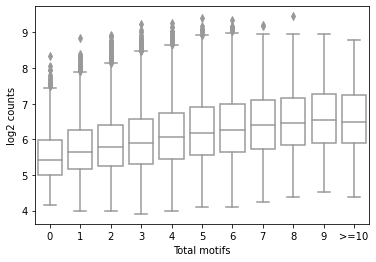

In [1144]:
sns.boxplot(x="Total motifs", 
            y="log2 counts",
                color="white",
            data=pd.DataFrame({
                "Total motifs":[x if x<=9 else ">=10" for x in subset_dens], 
                "log2 counts":subset_cts}
            ),
            order = list(range(10)) + [">=10"])

In [1145]:
pearsonr(subset_dens,
           subset_cts)

(0.21496104897487006, 0.0)

In [1146]:
pearsonr([len(x) for x in subset_filter_motif_instances],
           subset_cts)

(0.13833641479582548, 3.3355507520321504e-285)

<AxesSubplot:xlabel='peak set', ylabel='density'>

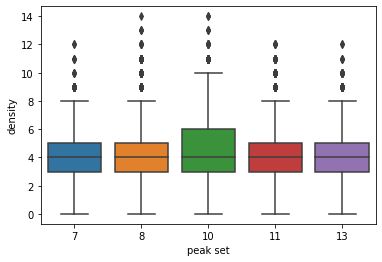

In [1147]:
sns.boxplot(x="peak set", 
            y="density",
#                 color="white",
            data=pd.DataFrame({
                "peak set":subset_idx, 
                "density":subset_dens}
            ))

<AxesSubplot:xlabel='Shared with Low OSK', ylabel='density'>

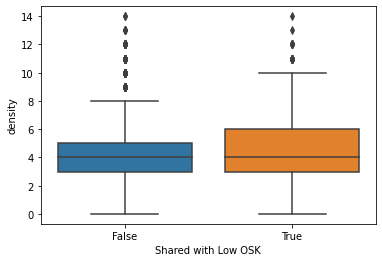

In [494]:
sns.boxplot(x="Shared with Low OSK", 
            y="density",
#                 color="white",
            data=pd.DataFrame({
                "Shared with Low OSK":subset_also_low_osk, 
                "density":subset_dens}
            ))

<AxesSubplot:xlabel='Shared with Low OSK', ylabel='Accessibility'>

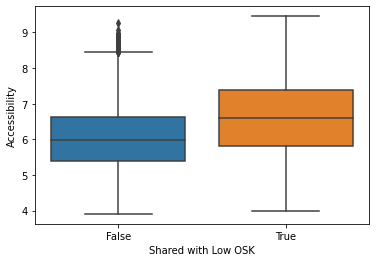

In [495]:
sns.boxplot(x="Shared with Low OSK", 
            y="Accessibility",
#                 color="white",
            data=pd.DataFrame({
                "Shared with Low OSK":subset_also_low_osk, 
                "Accessibility":subset_cts}
            ))

<AxesSubplot:xlabel='Shared with Low OSK', ylabel='Consecutive motif distance'>

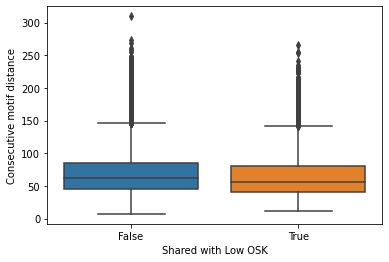

In [496]:
cur_select = [i for i,x in enumerate(subset_dens) if x>3]
cur_cons_dist = [subset_cons_dist[i] for i in cur_select]
cur_subset_also_low_osk = [subset_also_low_osk[i] for i in cur_select]

sns.boxplot(x="Shared with Low OSK", 
            y="Consecutive motif distance",
#                 color="white",
            data=pd.DataFrame({
                "Shared with Low OSK":cur_subset_also_low_osk, 
                "Consecutive motif distance":cur_cons_dist}
            ))

In [497]:
np.median([subset_cons_dist[i] for i in cur_select if subset_also_low_osk[i]==False])

62.75

In [498]:
np.median([subset_cons_dist[i] for i in cur_select if subset_also_low_osk[i]==True])

56.666666666666664

## Composition

In [499]:
subset_idx[:10]

[7, 11, 8, 10, 10, 10, 11, 11, 11, 8]

In [1148]:
motif_combinations = [(int(x["OCTSOX"]>0),
                 int(x["KLF"]>0),
                 int(x["SOX.not.OCTSOX"]>0),
                 int(x["AP1"]>0)) for x in subset_composition]

for p in [7,8,10,11,13,"All"]:
    print(p)
    
    if p!="All":
        peak_idx_combination = [x for i,x in enumerate(motif_combinations) if subset_idx[i]==p]
    else:
        peak_idx_combination = motif_combinations
        
    counts = Counter(peak_idx_combination).most_common()

    for x,y in counts:
        print(x, "{:4d}".format(y), "{:.2f}".format(100*y/len(peak_idx_combination)))
    print()

7
(0, 1, 0, 0) 1472 35.55
(1, 1, 0, 0)  887 21.42
(0, 1, 1, 0)  469 11.33
(1, 1, 1, 0)  403 9.73
(0, 1, 0, 1)  232 5.60
(1, 1, 0, 1)  228 5.51
(0, 0, 0, 0)   95 2.29
(1, 1, 1, 1)   94 2.27
(0, 1, 1, 1)   92 2.22
(1, 0, 0, 0)   65 1.57
(1, 0, 1, 0)   49 1.18
(1, 0, 0, 1)   19 0.46
(1, 0, 1, 1)   16 0.39
(0, 0, 1, 0)   11 0.27
(0, 0, 0, 1)    8 0.19
(0, 0, 1, 1)    1 0.02

8
(1, 1, 0, 0) 7196 30.93
(1, 1, 1, 0) 5812 24.98
(0, 1, 0, 0) 2091 8.99
(0, 1, 1, 0) 1872 8.05
(1, 1, 0, 1) 1308 5.62
(1, 0, 1, 0) 1154 4.96
(1, 1, 1, 1) 1094 4.70
(1, 0, 0, 0) 1090 4.69
(0, 1, 0, 1)  318 1.37
(0, 1, 1, 1)  312 1.34
(1, 0, 1, 1)  296 1.27
(1, 0, 0, 1)  285 1.23
(0, 0, 1, 0)  182 0.78
(0, 0, 0, 0)  168 0.72
(0, 0, 1, 1)   46 0.20
(0, 0, 0, 1)   40 0.17

10
(1, 1, 0, 0) 5958 31.79
(1, 1, 1, 0) 4775 25.48
(1, 0, 1, 0) 1457 7.77
(1, 0, 0, 0) 1400 7.47
(1, 1, 0, 1) 1249 6.66
(1, 1, 1, 1) 1076 5.74
(0, 1, 0, 0)  782 4.17
(0, 1, 1, 0)  705 3.76
(1, 0, 0, 1)  476 2.54
(1, 0, 1, 1)  425 2.27
(0, 1, 0, 1)  135 

In [845]:
shuffled_motif_combinations = [list(x) for x in list(zip(*motif_combinations))]
for i in range(len(shuffled_motif_combinations)):
    shuffle(shuffled_motif_combinations[i])

counts = Counter(list(zip(*shuffled_motif_combinations))).most_common()

for x,y in counts:
    print(x, "{:5d}".format(y), "{:.2f}".format(100*y/len(shuffled_motif_combinations[0])))
print()  

(1, 1, 0, 0) 21351 31.20
(1, 1, 1, 0) 15576 22.76
(0, 1, 0, 0)  5792 8.46
(1, 0, 0, 0)  4824 7.05
(0, 1, 1, 0)  4161 6.08
(1, 1, 0, 1)  4076 5.96
(1, 0, 1, 0)  3593 5.25
(1, 1, 1, 1)  2934 4.29
(0, 0, 0, 0)  1289 1.88
(0, 1, 0, 1)  1079 1.58
(0, 0, 1, 0)   961 1.40
(1, 0, 0, 1)   884 1.29
(0, 1, 1, 1)   820 1.20
(1, 0, 1, 1)   668 0.98
(0, 0, 0, 1)   243 0.36
(0, 0, 1, 1)   183 0.27



In [843]:
motif_combinations = [(int(x["OCTSOX"]>0),
                 int(x["KLF"]>0),
                 int(x["SOX.not.OCTSOX"]>0),
                 int(x["AP1"]>0)) for x in subset_composition]

for p in [True, False]:
    print(p)
    
    peak_idx_combination = [x for i,x in enumerate(motif_combinations) if subset_also_low_osk[i]==p]
        
    counts = Counter(peak_idx_combination).most_common()

    for x,y in counts:
        print(x, "{:4d}".format(y), "{:.2f}".format(100*y/len(peak_idx_combination)))
    print()

True
(1, 1, 0, 0) 4169 31.77
(1, 1, 1, 0) 2493 19.00
(1, 1, 0, 1) 1203 9.17
(0, 1, 0, 0)  957 7.29
(1, 0, 0, 0)  848 6.46
(1, 0, 1, 0)  728 5.55
(1, 1, 1, 1)  708 5.40
(0, 1, 1, 0)  634 4.83
(1, 0, 0, 1)  412 3.14
(1, 0, 1, 1)  304 2.32
(0, 1, 0, 1)  294 2.24
(0, 1, 1, 1)  206 1.57
(0, 0, 0, 0)   85 0.65
(0, 0, 1, 0)   35 0.27
(0, 0, 0, 1)   25 0.19
(0, 0, 1, 1)   22 0.17

False
(1, 1, 0, 0) 17191 31.08
(1, 1, 1, 0) 12253 22.15
(0, 1, 0, 0) 5740 10.38
(0, 1, 1, 0) 4055 7.33
(1, 0, 1, 0) 3681 6.66
(1, 0, 0, 0) 3663 6.62
(1, 1, 0, 1) 2672 4.83
(1, 1, 1, 1) 1930 3.49
(1, 0, 0, 1)  886 1.60
(1, 0, 1, 1)  765 1.38
(0, 1, 0, 1)  723 1.31
(0, 0, 0, 0)  596 1.08
(0, 1, 1, 1)  561 1.01
(0, 0, 1, 0)  419 0.76
(0, 0, 1, 1)  102 0.18
(0, 0, 0, 1)   74 0.13



In [694]:
Counter([(int(x["OCTSOX"]>0),
          int(x["KLF"]>0),
          int(x["SOX.not.OCTSOX"]>0),
          int(x["AP1"]>0)) for i,x in enumerate(subset_composition)]).most_common()

[((1, 1, 0, 0), 21360),
 ((1, 1, 1, 0), 14746),
 ((0, 1, 0, 0), 6697),
 ((0, 1, 1, 0), 4689),
 ((1, 0, 0, 0), 4511),
 ((1, 0, 1, 0), 4409),
 ((1, 1, 0, 1), 3875),
 ((1, 1, 1, 1), 2638),
 ((1, 0, 0, 1), 1298),
 ((1, 0, 1, 1), 1069),
 ((0, 1, 0, 1), 1017),
 ((0, 1, 1, 1), 767),
 ((0, 0, 0, 0), 681),
 ((0, 0, 1, 0), 454),
 ((0, 0, 1, 1), 124),
 ((0, 0, 0, 1), 99)]

In [384]:
print(Counter([len(x) for i,x in enumerate(subset_composition) if subset_idx[i]==8]))
print(sum([x["OCTSOX"]>0 for i,x in enumerate(subset_composition) if subset_idx[i]==8]))
print(len([x for x in subset_idx if x==8]))

Counter({2: 13906, 1: 7294, 3: 1959, 0: 521})
18240
23680


In [385]:
print(Counter([len(x) for i,x in enumerate(subset_composition) if subset_idx[i]==11]))
print(sum([x["OCTSOX"]>0 for i,x in enumerate(subset_composition) if subset_idx[i]==11]))
print(len([x for x in subset_idx if x==11]))

Counter({2: 9467, 1: 3959, 3: 1871, 0: 152})
12725
15449


In [386]:
print(Counter([len(x) for i,x in enumerate(subset_composition) if subset_idx[i]==13]))
print(sum([x["OCTSOX"]>0 for i,x in enumerate(subset_composition) if subset_idx[i]==13]))
print(len([x for x in subset_idx if x==13]))

Counter({2: 3606, 1: 1984, 3: 439, 0: 145})
4412
6174


In [501]:
peak_set_2_aff = defaultdict(list)
SEL_MOT = "OCTSOX"

for chrm in scanned_peaks_intervals:
    for peak in scanned_peaks_intervals[chrm]:
            affs = [x.data[1] for x in motif_its[chrm][peak.begin:peak.end] if x.data[0]==SEL_MOT]
            
            if affs:
#                 peak_set_2_aff[peak.data] += affs
                peak_set_2_aff[peak.data[0]].append(max(affs))                

In [502]:
np.median(peak_set_2_aff[8])

7.818887

In [503]:
np.median(peak_set_2_aff[10])

8.346871499999999

In [504]:
np.median(peak_set_2_aff[11])

8.414899

In [505]:
np.median(peak_set_2_aff[13])

8.629926000000001

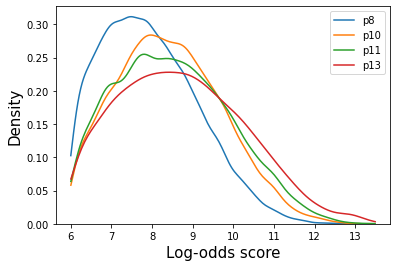

In [506]:
for p in [8,10,11,13]:
    sns.kdeplot(peak_set_2_aff[p], label='p' + str(p), cut=0)
plt.xlabel("Log-odds score", fontsize=15)
plt.ylabel("Density", fontsize=15)
plt.legend()
# plt.savefig("tmp.pdf")
# pd.Series(logodds_p11).hist(bins=50,alpha=0.5)

Text(0, 0.5, 'Log-odds')

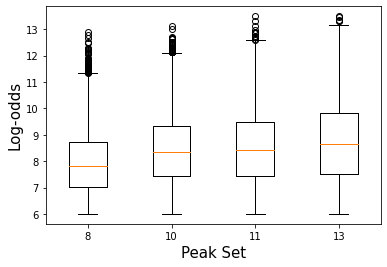

In [507]:
plt.boxplot([peak_set_2_aff[p] for p in [8,10,11,13]],
            labels=[8,10,11,13])
plt.xlabel("Peak Set", fontsize=15)
plt.ylabel("Log-odds", fontsize=15)
# plt.show()

In [508]:
print(scipy.stats.mannwhitneyu(peak_set_2_aff[10], peak_set_2_aff[8])[1])
print(scipy.stats.mannwhitneyu(peak_set_2_aff[10], peak_set_2_aff[11])[1])
print(scipy.stats.mannwhitneyu(peak_set_2_aff[11], peak_set_2_aff[8])[1])
print(scipy.stats.mannwhitneyu(peak_set_2_aff[11], peak_set_2_aff[13])[1])
print(scipy.stats.mannwhitneyu(peak_set_2_aff[8], peak_set_2_aff[13])[1])

2.3969986656815802e-268
8.412783897809838e-05
9.430890367948933e-262
4.7141052825717504e-14
4.55149833554423e-202


In [509]:
low_osk_peak_2_aff = defaultdict(list)
SEL_MOT = "OCTSOX"

for chrm in scanned_peaks_intervals:
    for peak in scanned_peaks_intervals[chrm]:
            affs = [x.data[1] for x in motif_its[chrm][peak.begin:peak.end] if x.data[0]==SEL_MOT]
            
            if affs:
#                 peak_set_2_aff[peak.data] += affs
                low_osk_peak_2_aff[peak.data[1]].append(max(affs))                

In [510]:
print(np.median(low_osk_peak_2_aff[True]), np.median(low_osk_peak_2_aff[False]))

8.570931 7.9900009999999995


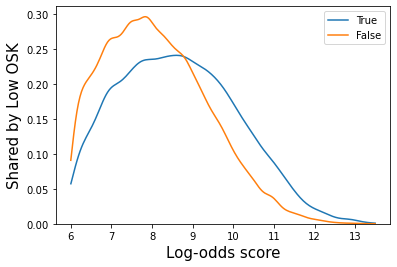

In [511]:
for p in [True, False]:
    sns.kdeplot(low_osk_peak_2_aff[p], label=str(p), cut=0)
plt.xlabel("Log-odds score", fontsize=15)
plt.ylabel("Shared by Low OSK", fontsize=15)
plt.legend()
# plt.savefig("tmp.pdf")
# pd.Series(logodds_p11).hist(bins=50,alpha=0.5)

Text(0, 0.5, 'Log-odds')

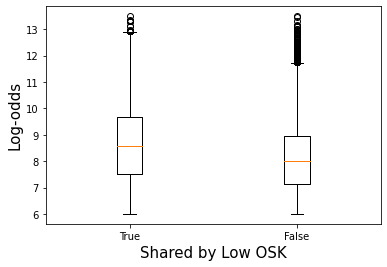

In [512]:
plt.boxplot([low_osk_peak_2_aff[p] for p in [True, False]],
            labels=[True,False])
plt.xlabel("Shared by Low OSK", fontsize=15)
plt.ylabel("Log-odds", fontsize=15)
# plt.show()

In [513]:
print(scipy.stats.mannwhitneyu(low_osk_peak_2_aff[True], low_osk_peak_2_aff[False])[1])

0.0


## Simple feature classifiers

Use simple features like affinity, density to predict accessibility/peak class (e.g. peak set or shared with low OSK)

In [1030]:
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.neural_network import MLPClassifier, MLPRegressor

In [1150]:
# features/labels
subset = [x for x in density_x_counts[0] if x[7] in [8,11]]# and 6==x[0]]
subset_dens = [x[0] for x in subset]
subset_cts = [x[1] for x in subset]
subset_cons_dist = [x[2] for x in subset]
subset_eff_dens = [x[3] for x in subset]
subset_composition = [x[4] for x in subset]
subset_motif_instances = [x[5] for x in subset]
subset_gc = [x[6][0] for x in subset]
subset_gc_200 = [x[6][1] for x in subset]
subset_gc_500 = [x[6][2] for x in subset]
subset_idx = [x[7] for x in subset]
subset_also_low_osk = [x[8] for x in subset]

subset_OS_counts = [x["OCTSOX"] for x in subset_composition]
subset_K_counts = [x["KLF"] for x in subset_composition]
subset_S_counts = [x["SOX.not.OCTSOX"] for x in subset_composition]
subset_AP1_counts = [x["AP1"] for x in subset_composition]

In [1151]:
subset_high_aff_dens = [len(filter_motif(x)) for x in subset_motif_instances]

In [1152]:
def get_aff_feat(motif_instances, motif, reduce=np.max):
    affs = [[y[1] for y in x if y[0]==motif] for x in motif_instances]

    non_missing_min = np.min([y for x in affs for y in x])

    reduced_affs = [reduce(x) if len(x)>0 else non_missing_min for x in affs]
    
    return reduced_affs
    

In [1153]:
subset_OS_aff_max = get_aff_feat(subset_motif_instances, "OCTSOX", reduce=np.max)
subset_K_aff_max = get_aff_feat(subset_motif_instances, "KLF", reduce=np.max)
subset_S_aff_max = get_aff_feat(subset_motif_instances, "SOX.not.OCTSOX", reduce=np.max)
subset_AP1_aff_max = get_aff_feat(subset_motif_instances, "AP1", reduce=np.max)

In [1154]:
subset_OS_aff_min = get_aff_feat(subset_motif_instances, "OCTSOX", reduce=np.min)
subset_K_aff_min = get_aff_feat(subset_motif_instances, "KLF", reduce=np.min)
subset_S_aff_min = get_aff_feat(subset_motif_instances, "SOX.not.OCTSOX", reduce=np.min)
subset_AP1_aff_min = get_aff_feat(subset_motif_instances, "AP1", reduce=np.min)

In [1155]:
subset_OS_aff_mean = get_aff_feat(subset_motif_instances, "OCTSOX", reduce=np.mean)
subset_K_aff_mean = get_aff_feat(subset_motif_instances, "KLF", reduce=np.mean)
subset_S_aff_mean = get_aff_feat(subset_motif_instances, "SOX.not.OCTSOX", reduce=np.mean)
subset_AP1_aff_mean = get_aff_feat(subset_motif_instances, "AP1", reduce=np.mean)

In [1156]:
len(subset)

38489

In [1170]:
X = pd.DataFrame({
#     "gc": subset_gc,
#     "gc_200": subset_gc_200,
#     "gc_500": subset_gc_500, 
    
    "total_counts": subset_dens,
    "high_aff_counts": subset_high_aff_dens,
    
    "OS_counts": subset_OS_counts,
    "K_counts": subset_K_counts,
    "S_counts": subset_S_counts,
    "AP1_counts": subset_AP1_counts,
    
    "cons_dist": subset_cons_dist,
    
    "OS_aff_max": subset_OS_aff_max,
    "K_aff_max": subset_K_aff_max,
    "S_aff_max": subset_S_aff_max,
    "AP1_aff_max": subset_AP1_aff_max,
    
    "OS_aff_min": subset_OS_aff_min,
    "K_aff_min": subset_K_aff_min,
    "S_aff_min": subset_S_aff_min,
    "AP1_aff_min": subset_AP1_aff_min,
    
    "OS_aff_mean": subset_OS_aff_mean,
    "K_aff_mean": subset_K_aff_mean,
    "S_aff_mean": subset_S_aff_mean,
    "AP1_aff_mean": subset_AP1_aff_mean
})

In [1171]:
# y = subset_cts

In [1172]:
# y = subset_also_low_osk

In [1173]:
y = [x==11 for x in subset_idx]
sum(y)/len(y)

0.39556756475876226

In [1174]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

In [1175]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [1176]:
# clf = LinearRegression().fit(X_train, y_train)

In [1177]:
# clf = LogisticRegression().fit(X_train, y_train)

In [1178]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                     hidden_layer_sizes=(5,2), 
                    random_state=1,
                    max_iter=2000,
                   early_stopping=True).fit(X_train, y_train)

In [1179]:
# pearsonr(y_test, clf.predict(X_test))

In [1180]:
# plt.scatter(y_test, clf.predict(X_test), s=1, alpha=0.3)

In [1181]:
average_precision_score(y_test, clf.predict_proba(X_test)[:,1])

0.5822307939701534

In [1182]:
roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

0.6834249113137043